In [87]:
import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [88]:
import pandas as pd
import numpy as np
import os
import torch
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

output_nums=4


# 修改后的createXY函数
def createXY(dataset: pd.DataFrame, n_past: int, n_future: int, column_target: str):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)
        dataY.append(dataset.iloc[i:i + n_future][column_target].values)
    return np.array(dataX), np.array(dataY)

# 修改后的process_files函数
def process_files(columns_all, column_target, folder_path, n_past=1, n_future=1):
    all_dataX, all_dataY = np.array([]), np.array([])
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            series = pd.read_csv(file_path)
            single_dataset = series[columns_all]
            dataX, dataY = createXY(single_dataset, n_past, n_future, column_target)
            all_dataX = np.vstack([all_dataX, dataX]) if all_dataX.size else dataX
            all_dataY = np.vstack([all_dataY, dataY]) if all_dataY.size else dataY
    return all_dataX, all_dataY


columns_all=['CGM (mg / dl)','insulin','carbohydrate','protein','fat','cellulose','hour_sin','hour_cos','CGM_diff']
# columns_all = ['CGM (mg / dl)','CSII - basal insulin (Novolin R, IU / H)']
column_target = ['CGM (mg / dl)']
folder_path = '../diabetes_datasets/T2'

# 使用n_past=8, n_future=4调用process_files
n_past=8
dataX, dataY = process_files(columns_all, column_target, folder_path, n_past=n_past, n_future=output_nums)



In [89]:
dataY_for_train=dataY[:,0,:].reshape(-1,1,1)

In [90]:
dataX.shape,dataY.shape,dataY_for_train.shape

((111142, 8, 9), (111142, 4, 1), (111142, 1, 1))

In [91]:
dataY[0],dataY_for_train[0]

(array([[68.4],
        [75.6],
        [61.2],
        [48.6]]),
 array([[68.4]]))

In [92]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn, optim
from torch.utils.data import Subset

# 假设dataX和dataY是你的数据
# 将它们转换为PyTorch张量，这里假设它们已经是Tensor或者从Numpy转换过来的
dataX_tensor = torch.tensor(dataX, dtype=torch.float32)
dataY_tensor = torch.tensor(dataY_for_train, dtype=torch.float32)

# 创建TensorDataset对象
dataset = TensorDataset(dataX_tensor, dataY_tensor)

# 其余拆分数据集、创建DataLoader对象的代码与之前相同
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)


# # 随机拆分数据集
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

assert train_size + val_size + test_size == len(dataset)
# 按照顺序划分数据集
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
test_dataset = Subset(dataset, range(train_size + val_size, len(dataset)))


batch_size = 32
# 创建DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
feature_nums = dataX.shape[2]


In [95]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim=feature_nums, output_dim=1, d_model=4, nhead=2, num_encoder_layers=1, dropout=0.2):
        super(TransformerEncoderModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        
        # 使用线性层代替嵌入层
        self.linear_input = nn.Linear(self.input_dim, self.d_model)

        # 多头自注意力层
        encoder_layers = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=self.num_encoder_layers)

        # 输出层
        self.linear_out = nn.Linear(self.d_model, self.output_dim)

    def forward(self, x):
        # 通过线性层
        x = self.linear_input(x)

        # 通过Transformer编码器
        x = self.transformer_encoder(x)

        # 取最后一个时间步的输出
        x = x[:, -1, :]

        # 通过输出层
        x = self.linear_out(x)

        return x

### 从零训练和测试

In [96]:
model = TransformerEncoderModel().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 早停法参数
best_val_loss = float('inf')
patience = 10
patience_counter = 0
max_epochs = 5000

for epoch in range(max_epochs):
    train_loss = 0
    model.train()
    
    # Training loop
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    # 每个epoch后，在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(-1)  # 调整目标尺寸
            output = model(data)
            val_loss += criterion(output, target).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch}: Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # 早停法逻辑
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 保存最好的模型状态
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch} epochs.')
        model.load_state_dict(best_model_state)
        break



Epoch 0: Training Loss: 111.74973913346508, Validation Loss: 58.02585615597183
Epoch 1: Training Loss: 40.984124324143274, Validation Loss: 41.41164017203901
Epoch 2: Training Loss: 34.544545882036495, Validation Loss: 36.578032524465655
Epoch 3: Training Loss: 31.50892110200395, Validation Loss: 32.701352321844304
Epoch 4: Training Loss: 27.0026870629609, Validation Loss: 22.851639658084018
Epoch 5: Training Loss: 20.204048648448, Validation Loss: 14.647414465087781
Epoch 6: Training Loss: 16.60901298861586, Validation Loss: 11.845124642625986
Epoch 7: Training Loss: 14.633969795909815, Validation Loss: 11.223355126209396
Epoch 8: Training Loss: 13.296113910235736, Validation Loss: 10.214333694787333
Epoch 9: Training Loss: 12.339666278600236, Validation Loss: 9.52434218461565
Epoch 10: Training Loss: 11.553793046501914, Validation Loss: 7.712787727314791
Epoch 11: Training Loss: 10.943486533672933, Validation Loss: 7.564846831946064
Epoch 12: Training Loss: 10.620726905834651, Valida

In [97]:
import torch

# 保存模型的状态字典到文件
torch.save(model.state_dict(), '../model/T2/transformerEncoderMultiStep1.pth')


In [60]:
dataX.shape

(111142, 8, 9)

In [98]:
testX=dataX[train_size + val_size:,:,:]
testY=dataY[train_size + val_size:,:,:]
testX=torch.tensor(testX, dtype=torch.float32).to(device)
testY=torch.tensor(testY, dtype=torch.float32).to(device)

In [62]:
testX[1]

tensor([[104.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -0.2588,
           0.9659,   0.0000],
        [102.6000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -0.2588,
           0.9659,  -1.8000],
        [102.6000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -0.2588,
           0.9659,   0.0000],
        [102.6000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           1.0000,   0.0000],
        [102.6000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           1.0000,   0.0000],
        [102.6000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           1.0000,   0.0000],
        [104.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           1.0000,   1.8000],
        [106.2000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.2588,
           0.9659,   1.8000]], device='cuda:0')

In [13]:
# # 加载最佳模型状态
# model.load_state_dict(best_model_state)
# criterion_mae=nn.L1Loss()
# # 在测试集上验证模型并输出预测标签
# model.eval()
# test_loss = 0
# test_loss_mae=0
# all_predictions = []
# all_targets = []
# with torch.no_grad():
#     for data, target in test_loader:
#         data, target = data.to(device), target.to(device)
        
#         target = target.squeeze(-1)  # 调整目标尺寸
#         output = model(data)
#         test_loss += criterion(output, target).item()
#         test_loss_mae+=criterion_mae(output, target).item()
#         all_predictions.append(output.cpu().numpy())
#         all_targets.append(target.cpu().numpy())

# test_loss /= len(test_loader)
# test_loss_mae/=len(test_loader)
# print(f'Test Loss: {test_loss}')
# print(f'Test Loss mae: {test_loss_mae}')

### 从磁盘上load

In [103]:
model=TransformerEncoderModel().to(device)
model.load_state_dict(torch.load('../model/T2/TransformerEncoder.pth'))

<All keys matched successfully>

In [81]:
testX.shape,testY.shape

(torch.Size([22229, 8, 9]), torch.Size([22229, 4, 1]))

In [104]:
testX = dataX[train_size + val_size:, :, :]
testY = dataY[train_size + val_size:, :, :]
testX = torch.tensor(testX, dtype=torch.float32).to(device)
testY = torch.tensor(testY, dtype=torch.float32).to(device)

In [105]:
criterion = nn.L1Loss()
output=[]

def eval():
    model.eval()
    with torch.no_grad():
        output = model(testX)
    return output


for i in range(output_nums):
    output_single = eval()
    output.append(output_single)
    testX = testX[1:, :, :]   
    for j in range(i+1):
        testX[:,-1-j,0]=output[-1-j][:-1-j].reshape(-1)





In [106]:
target_ground_truth =testY[:,0,:]
target_ground_truth.shape


torch.Size([22229, 1])

In [85]:
output[0].shape

torch.Size([22229, 1])

In [107]:
total_mae=0
for i in range(output_nums):
    MAE=criterion(output[i],target_ground_truth[-output[i].shape[0]:,:])
    total_mae+=MAE
    print(f'MAE for {i+1} step prediction is {MAE}')


print(f'Total MAE is {total_mae/4}')

MAE for 1 step prediction is 5.9798712730407715
MAE for 2 step prediction is 9.657912254333496
MAE for 3 step prediction is 11.955255508422852
MAE for 4 step prediction is 13.884456634521484
Total MAE is 10.369373321533203


### 可视化分别看1步-4步

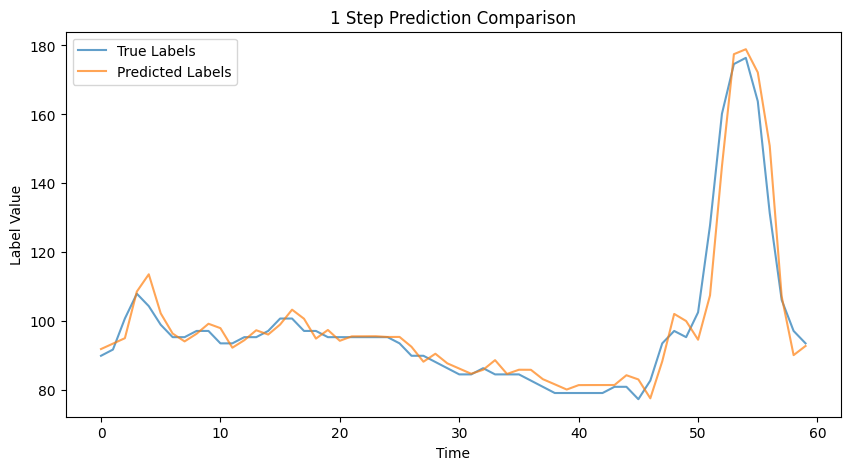

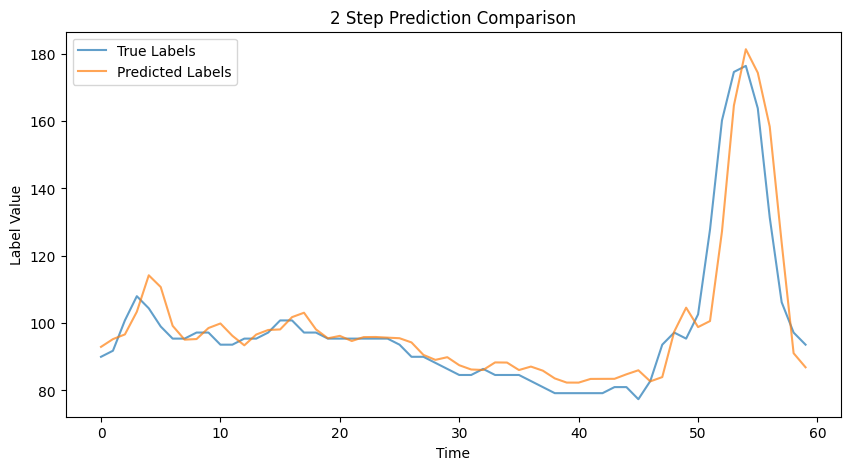

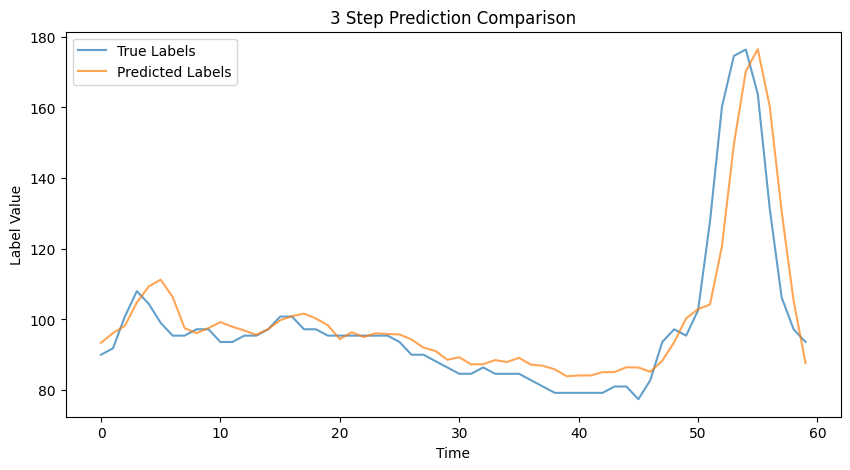

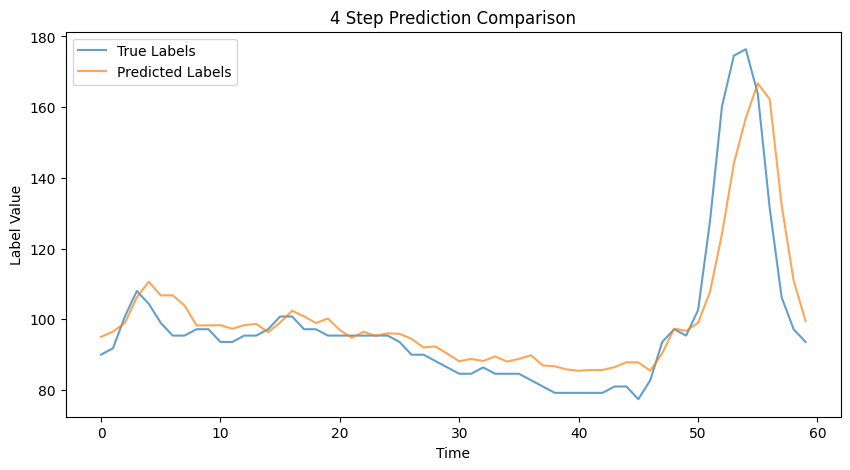

In [108]:
import matplotlib.pyplot as plt


last_shown=60
for i in range(output_nums):
    # 画出比对图
    plt.figure(figsize=(10, 5))
    plt.plot(target_ground_truth.reshape(-1)[-last_shown:].cpu().numpy(), label='True Labels', alpha=0.7)
    plt.plot(output[i].reshape(-1)[-last_shown:].cpu().numpy(), label='Predicted Labels', alpha=0.7)
    plt.legend()
    plt.title(f'{i+1} Step Prediction Comparison')
    plt.xlabel('Time')
    plt.ylabel('Label Value')
    plt.show()
